##Checking GPU and RAM

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Mar 13 16:26:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


##Installing Libs (versions)

In [ ]:
# !pip3 install tensorflow==2.8.0
# !pip3 install keras==2.3.1
# !pip3 install segmentation_models

##Importing Libs

In [ ]:
import tensorflow
import sys
import glob
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
# import segmentation_models as sm

##Defining Root Path

In [ ]:
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/GO characterization')

In [ ]:
#Resizing images, if needed
SIZE_X = 512 
SIZE_Y = 512 
n_classes = 2 #Number of classes for segmentation

##Importing Images (Dataset)

In [ ]:
images=[]
masks = []

for fold in range(1,6):
  for image in range(1,526):
    img = cv2.imread(f'/content/drive/MyDrive/Colab Notebooks/U-net Graphene Segmentation Final/Data/images/k{fold}/{image}.bmp', 0)
    images.append(img)
    img = cv2.imread(f'/content/drive/MyDrive/Colab Notebooks/U-net Graphene Segmentation Final/Data/masks/k{fold}/{image}.bmp', 0)
    masks.append(img)

images = np.array(images)
masks = np.array(masks)

img = None

##Checking Arrays

In [ ]:
print('Images shape: ', images.shape)
print('Masks shape: ', masks.shape)
print('Values masks: ', np.unique(masks))

Images shape:  (2625, 512, 512)
Masks shape:  (2625, 512, 512)
Values masks:  [  0 255]


##Transforming data

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = masks.shape

# train_masks_reshaped = train_masks.reshape(-1,1)
masks = masks.ravel()
masks = labelencoder.fit_transform(masks)
masks = masks.reshape(n, h, w)
masks = np.expand_dims(masks, axis=3)

print('Masks shape: ', masks.shape)
print('Values masks: ', np.unique(masks))

Masks shape:  (2625, 512, 512, 1)
Values masks:  [0 1]


In [ ]:
from tensorflow.keras.utils import to_categorical
n, h, w, g = masks.shape
masks = to_categorical(masks, num_classes=n_classes)
masks = masks.reshape((n, h, w, n_classes))

print('Masks shape: ', masks.shape)
print('Values masks: ', np.unique(masks))

Masks shape:  (2625, 512, 512, 2)
Values masks:  [0. 1.]


In [ ]:
images = np.expand_dims(images, axis=3)
images = images/255

##Checking if images and maks are in same position

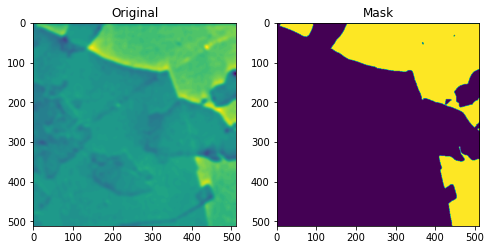

In [ ]:
image_number = random.randint(0, len(images))

plt.figure(figsize=(8, 8))
plt.subplot(121)
plt.title('Original')
plt.imshow(np.reshape(images[image_number], (512,512)))
plt.subplot(122)
plt.title('Mask')
plt.imshow(np.reshape(masks[image_number,:,:,1], (512,512)))
plt.show()

##Cross Validation K-fold

In [ ]:
def k_fold_method(X_data, y_data, k_fold, n_routine):
  n, h, w, g = X_data.shape
  x = int(n/k_fold)

  if (n_routine==1):
    X_train = X_data[x:]
    y_train = y_data[x:]

    X_test = X_data[0:x]
    y_test = y_data[0:x]

  elif (n_routine==k_fold):
    X_train = X_data[0:-x]
    y_train = y_data[0:-x]

    X_test = X_data[-x:n_routine*x]
    y_test = y_data[-x:n_routine*x]
  
  else:
    X_train = np.vstack((X_data[0:n_routine*x], X_data[(n_routine+1)*x:]))
    y_train = np.vstack((y_data[0:n_routine*x], y_data[(n_routine+1)*x:]))

    X_test = X_data[n_routine*x:(n_routine+1)*x]
    y_test = y_data[n_routine*x:(n_routine+1)*x]

  return X_train, X_test, y_train, y_test

##Hiperparameters U-net

In [ ]:
IMG_HEIGHT = images.shape[1]
IMG_WIDTH  = images.shape[2]
IMG_CHANNELS = images.shape[3]

from u_net_model_5x5 import multi_unet_model, jaccard_coef, crossentropy

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [ ]:
# model = get_model()

metrics = ['accuracy', jaccard_coef]
loss_ = 'binary_crossentropy'
optimizer = 'Adam' #tensorflow.optimizers.Adam(learning_rate=0.001)
batch_size = 30
n_epochs = 200

# model.compile(optimizer=optimizer, loss=loss_, metrics=metrics)
# model.summary()

In [ ]:
# from numba import cuda
# # all of your code and execution
# cuda.select_device(0)

##Training With Cross Validation

Epoch 1/200
70/70 [==============================] - 42s 411ms/step - loss: 0.6213 - accuracy: 0.6382 - jaccard_coef: 0.4342 - val_loss: 0.5676 - val_accuracy: 0.6886 - val_jaccard_coef: 0.4796
Epoch 2/200
70/70 [==============================] - 25s 358ms/step - loss: 0.5511 - accuracy: 0.7141 - jaccard_coef: 0.5097 - val_loss: 0.5353 - val_accuracy: 0.7102 - val_jaccard_coef: 0.5117
Epoch 3/200
70/70 [==============================] - 25s 359ms/step - loss: 0.5259 - accuracy: 0.7277 - jaccard_coef: 0.5317 - val_loss: 0.5144 - val_accuracy: 0.7352 - val_jaccard_coef: 0.5196
Epoch 4/200
70/70 [==============================] - 25s 358ms/step - loss: 0.5882 - accuracy: 0.6861 - jaccard_coef: 0.4915 - val_loss: 0.6341 - val_accuracy: 0.6579 - val_jaccard_coef: 0.3978
Epoch 5/200
70/70 [==============================] - 25s 359ms/step - loss: 0.5664 - accuracy: 0.7048 - jaccard_coef: 0.4856 - val_loss: 0.5239 - val_accuracy: 0.7204 - val_jaccard_coef: 0.5140
Epoch 6/200
70/70 [===========

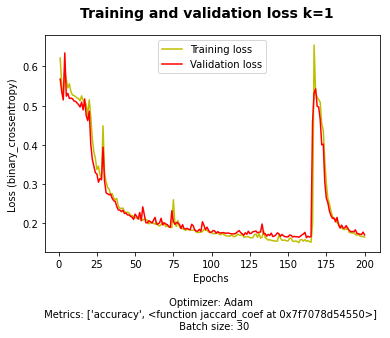

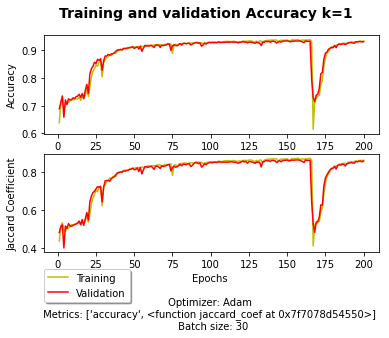

Epoch 1/200
70/70 [==============================] - 35s 384ms/step - loss: 0.7393 - accuracy: 0.5550 - jaccard_coef: 0.3725 - val_loss: 0.6615 - val_accuracy: 0.7179 - val_jaccard_coef: 0.3641
Epoch 2/200
70/70 [==============================] - 25s 358ms/step - loss: 0.6600 - accuracy: 0.5812 - jaccard_coef: 0.3772 - val_loss: 0.6796 - val_accuracy: 0.6227 - val_jaccard_coef: 0.3480
Epoch 3/200
70/70 [==============================] - 25s 357ms/step - loss: 0.6247 - accuracy: 0.6853 - jaccard_coef: 0.4211 - val_loss: 0.5726 - val_accuracy: 0.7319 - val_jaccard_coef: 0.4623
Epoch 4/200
70/70 [==============================] - 25s 358ms/step - loss: 0.6317 - accuracy: 0.6714 - jaccard_coef: 0.4271 - val_loss: 0.5946 - val_accuracy: 0.7371 - val_jaccard_coef: 0.4368
Epoch 5/200
70/70 [==============================] - 25s 358ms/step - loss: 0.5714 - accuracy: 0.7186 - jaccard_coef: 0.4876 - val_loss: 0.5326 - val_accuracy: 0.7375 - val_jaccard_coef: 0.5202
Epoch 6/200
70/70 [===========

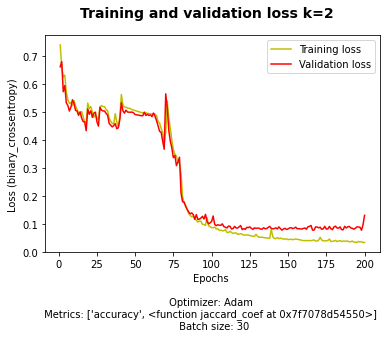

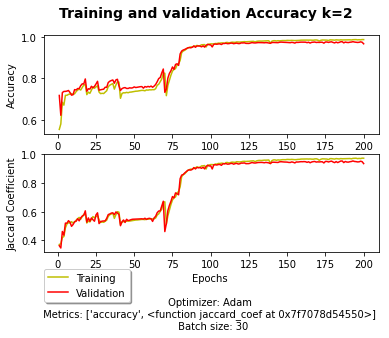

Epoch 1/200
70/70 [==============================] - 35s 388ms/step - loss: 0.6296 - accuracy: 0.6221 - jaccard_coef: 0.4186 - val_loss: 0.5454 - val_accuracy: 0.7157 - val_jaccard_coef: 0.5091
Epoch 2/200
70/70 [==============================] - 28s 406ms/step - loss: 0.5551 - accuracy: 0.7115 - jaccard_coef: 0.5068 - val_loss: 0.5494 - val_accuracy: 0.7081 - val_jaccard_coef: 0.5088
Epoch 3/200
70/70 [==============================] - 28s 405ms/step - loss: 0.5850 - accuracy: 0.6916 - jaccard_coef: 0.4765 - val_loss: 0.5619 - val_accuracy: 0.7113 - val_jaccard_coef: 0.4789
Epoch 4/200
70/70 [==============================] - 28s 404ms/step - loss: 0.5698 - accuracy: 0.7006 - jaccard_coef: 0.4865 - val_loss: 0.5308 - val_accuracy: 0.7174 - val_jaccard_coef: 0.5206
Epoch 5/200
70/70 [==============================] - 28s 405ms/step - loss: 0.5327 - accuracy: 0.7224 - jaccard_coef: 0.5230 - val_loss: 0.5260 - val_accuracy: 0.7190 - val_jaccard_coef: 0.5204
Epoch 6/200
70/70 [===========

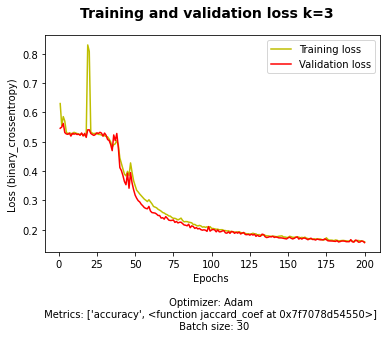

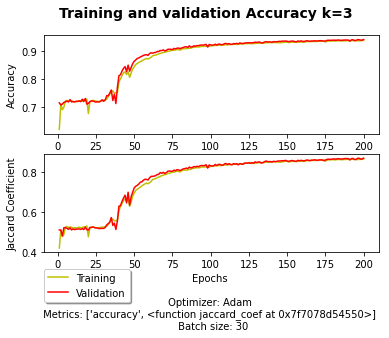

Epoch 1/200
70/70 [==============================] - 35s 382ms/step - loss: 0.6403 - accuracy: 0.6229 - jaccard_coef: 0.4077 - val_loss: 0.5465 - val_accuracy: 0.7050 - val_jaccard_coef: 0.5099
Epoch 2/200
70/70 [==============================] - 25s 357ms/step - loss: 0.5495 - accuracy: 0.7174 - jaccard_coef: 0.5157 - val_loss: 0.5523 - val_accuracy: 0.7162 - val_jaccard_coef: 0.4993
Epoch 3/200
70/70 [==============================] - 25s 357ms/step - loss: 0.5325 - accuracy: 0.7224 - jaccard_coef: 0.5236 - val_loss: 0.5402 - val_accuracy: 0.7136 - val_jaccard_coef: 0.5086
Epoch 4/200
70/70 [==============================] - 25s 358ms/step - loss: 0.5249 - accuracy: 0.7261 - jaccard_coef: 0.5269 - val_loss: 0.5409 - val_accuracy: 0.7148 - val_jaccard_coef: 0.5037
Epoch 5/200
70/70 [==============================] - 25s 358ms/step - loss: 0.5205 - accuracy: 0.7296 - jaccard_coef: 0.5300 - val_loss: 0.5323 - val_accuracy: 0.7136 - val_jaccard_coef: 0.5106
Epoch 6/200
70/70 [===========

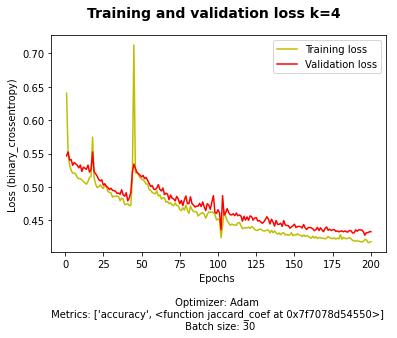

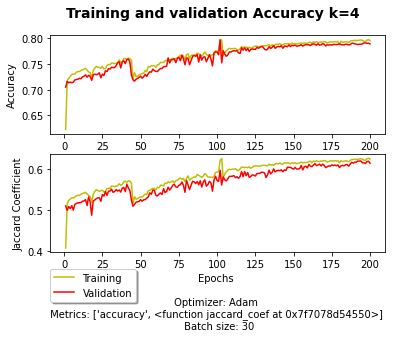

Epoch 1/200
70/70 [==============================] - 38s 437ms/step - loss: 0.6219 - accuracy: 0.6314 - jaccard_coef: 0.4296 - val_loss: 0.5580 - val_accuracy: 0.6898 - val_jaccard_coef: 0.4943
Epoch 2/200


ResourceExhaustedError: ignored

In [ ]:
# import time

# tic = time.clock() 

accuracy_list = []
loss_list = []
jaccard_coef_list =[]

k_fold = 5 #Number of folds

for n_routine in range(1,k_fold+1):
  X_train, X_test, y_train, y_test = k_fold_method(images, masks, k_fold, n_routine)

  # cuda.close()
  # device = cuda.get_current_device() 
  # device.reset()
  history = None
  model = None

  model = get_model()
  model.compile(optimizer=optimizer, loss=loss_, metrics=metrics)
  history = model.fit(X_train, y_train, 
                      batch_size = batch_size, 
                      verbose = 1, 
                      epochs = n_epochs, 
                      validation_data=(X_test, y_test),
                      shuffle=False)

  model.save('/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/GO characterization/Results/Weights/5x5/Weights_CV_{}.hdf5'.format(n_routine))

  #Evaluatting the model
  #plotting the training and validation accuracy at each epoch
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.suptitle('Training and validation loss k={}'.format(n_routine), fontsize=14, fontweight='bold')
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.xlabel('Epochs \n \n Optimizer: {}  \n Metrics: {}  \n Batch size: {}'.format(optimizer, metrics, batch_size))
  plt.ylabel('Loss ({})'.format(loss_))
  plt.legend()
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/GO characterization/Results/Performance/5x5/Loss k={}'.format(n_routine))
  plt.show()

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  jac_coef = history.history['jaccard_coef']
  val_jac_coef = history.history['val_jaccard_coef']

  fig, (ax1, ax2) = plt.subplots(2, 1)
  fig.suptitle('Training and validation Accuracy k={}'.format(n_routine), fontsize=14, fontweight='bold')
  ax1.plot(epochs, acc, 'y', label='Training')
  ax1.plot(epochs, val_acc, 'r', label='Validation')
  ax1.set_ylabel('Accuracy')
  ax2.plot(epochs, jac_coef, 'y', label='Training')
  ax2.plot(epochs, val_jac_coef, 'r', label='Validation')
  ax2.set_ylabel('Jaccard Coefficient')
  ax2.set_xlabel('Epochs \n \n Optimizer: {}  \n Metrics: {}  \n Batch size: {}'.format(optimizer, metrics, batch_size))
  ax2.legend(loc=(0,-0.5), shadow=True, fontsize=10)
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/GO characterization/Results/Performance/5x5/Accuracy k={}'.format(n_routine))
  plt.show()

  ###################################################################################3
  accuracy_list.append(history.history['val_accuracy'][59])
  loss_list.append(history.history['val_loss'][59])
  jaccard_coef_list.append(history.history['val_jaccard_coef'][59])

# toc = time.clock()
# print('Time Training: ', (toc - tic) / (60 * 60))
print('AVG Acc: ',np.average(accuracy_list)*100, '%')
print('AVG Loss: ', np.average(loss_list)*100, '%')
print('AVG IoU: ', np.average(jaccard_coef_list)*100, '%')

Epoch 1/200
70/70 [==============================] - 52s 412ms/step - loss: 0.6258 - accuracy: 0.6377 - jaccard_coef: 0.4227 - val_loss: 0.5175 - val_accuracy: 0.7279 - val_jaccard_coef: 0.5390
Epoch 2/200
70/70 [==============================] - 25s 361ms/step - loss: 0.6099 - accuracy: 0.6880 - jaccard_coef: 0.4675 - val_loss: 0.5712 - val_accuracy: 0.6813 - val_jaccard_coef: 0.4873
Epoch 3/200
70/70 [==============================] - 25s 361ms/step - loss: 0.5370 - accuracy: 0.7251 - jaccard_coef: 0.5252 - val_loss: 0.5536 - val_accuracy: 0.6875 - val_jaccard_coef: 0.5032
Epoch 4/200
70/70 [==============================] - 25s 361ms/step - loss: 0.5259 - accuracy: 0.7281 - jaccard_coef: 0.5328 - val_loss: 0.5407 - val_accuracy: 0.6921 - val_jaccard_coef: 0.5024
Epoch 5/200
70/70 [==============================] - 25s 360ms/step - loss: 0.5185 - accuracy: 0.7328 - jaccard_coef: 0.5384 - val_loss: 0.5211 - val_accuracy: 0.7237 - val_jaccard_coef: 0.5201
Epoch 6/200
70/70 [===========

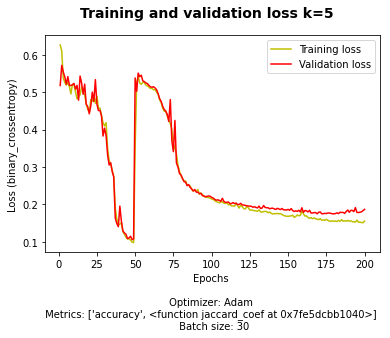

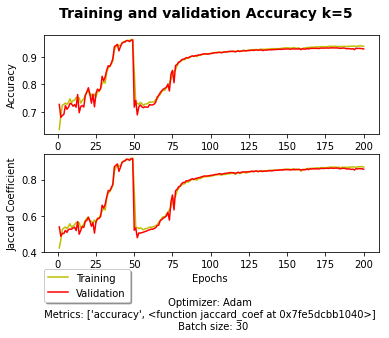

AVG Acc:  72.72257804870605 %
AVG Loss:  51.40594244003296 %
AVG IoU:  52.24461555480957 %


In [ ]:
# import time

# tic = time.clock() 

accuracy_list = []
loss_list = []
jaccard_coef_list =[]

k_fold = 5 #Number of folds

for n_routine in range(5,k_fold+1):
  X_train, X_test, y_train, y_test = k_fold_method(images, masks, k_fold, n_routine)

  # cuda.close()
  # device = cuda.get_current_device() 
  # device.reset()
  history = None
  model = None

  model = get_model()
  model.compile(optimizer=optimizer, loss=loss_, metrics=metrics)
  history = model.fit(X_train, y_train, 
                      batch_size = batch_size, 
                      verbose = 1, 
                      epochs = n_epochs, 
                      validation_data=(X_test, y_test),
                      shuffle=False)

  model.save('/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/GO characterization/Results/Weights/5x5/Weights_CV_{}.hdf5'.format(n_routine))

  #Evaluatting the model
  #plotting the training and validation accuracy at each epoch
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.suptitle('Training and validation loss k={}'.format(n_routine), fontsize=14, fontweight='bold')
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.xlabel('Epochs \n \n Optimizer: {}  \n Metrics: {}  \n Batch size: {}'.format(optimizer, metrics, batch_size))
  plt.ylabel('Loss ({})'.format(loss_))
  plt.legend()
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/GO characterization/Results/Performance/5x5/Loss k={}'.format(n_routine))
  plt.show()

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  jac_coef = history.history['jaccard_coef']
  val_jac_coef = history.history['val_jaccard_coef']

  fig, (ax1, ax2) = plt.subplots(2, 1)
  fig.suptitle('Training and validation Accuracy k={}'.format(n_routine), fontsize=14, fontweight='bold')
  ax1.plot(epochs, acc, 'y', label='Training')
  ax1.plot(epochs, val_acc, 'r', label='Validation')
  ax1.set_ylabel('Accuracy')
  ax2.plot(epochs, jac_coef, 'y', label='Training')
  ax2.plot(epochs, val_jac_coef, 'r', label='Validation')
  ax2.set_ylabel('Jaccard Coefficient')
  ax2.set_xlabel('Epochs \n \n Optimizer: {}  \n Metrics: {}  \n Batch size: {}'.format(optimizer, metrics, batch_size))
  ax2.legend(loc=(0,-0.5), shadow=True, fontsize=10)
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/GO characterization/Results/Performance/5x5/Accuracy k={}'.format(n_routine))
  plt.show()

  ###################################################################################3
  accuracy_list.append(history.history['val_accuracy'][59])
  loss_list.append(history.history['val_loss'][59])
  jaccard_coef_list.append(history.history['val_jaccard_coef'][59])

# toc = time.clock()
# print('Time Training: ', (toc - tic) / (60 * 60))
print('AVG Acc: ',np.average(accuracy_list)*100, '%')
print('AVG Loss: ', np.average(loss_list)*100, '%')
print('AVG IoU: ', np.average(jaccard_coef_list)*100, '%')

Epoch 1/200
70/70 [==============================] - 34s 382ms/step - loss: 0.6460 - accuracy: 0.5984 - jaccard_coef: 0.3968 - val_loss: 0.5606 - val_accuracy: 0.7040 - val_jaccard_coef: 0.4836
Epoch 2/200
70/70 [==============================] - 25s 358ms/step - loss: 0.5704 - accuracy: 0.7074 - jaccard_coef: 0.4945 - val_loss: 0.5284 - val_accuracy: 0.7161 - val_jaccard_coef: 0.5173
Epoch 3/200
70/70 [==============================] - 25s 359ms/step - loss: 0.5372 - accuracy: 0.7200 - jaccard_coef: 0.5209 - val_loss: 0.5300 - val_accuracy: 0.7157 - val_jaccard_coef: 0.5075
Epoch 4/200
70/70 [==============================] - 25s 359ms/step - loss: 0.5311 - accuracy: 0.7243 - jaccard_coef: 0.5234 - val_loss: 0.5190 - val_accuracy: 0.7191 - val_jaccard_coef: 0.5175
Epoch 5/200
70/70 [==============================] - 25s 359ms/step - loss: 0.5253 - accuracy: 0.7263 - jaccard_coef: 0.5271 - val_loss: 0.5187 - val_accuracy: 0.7179 - val_jaccard_coef: 0.5151
Epoch 6/200
70/70 [===========

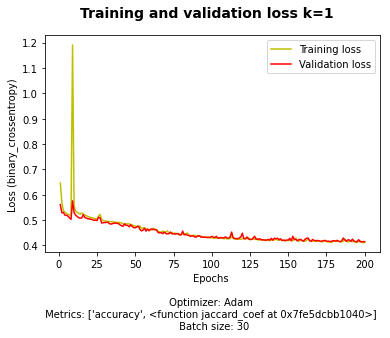

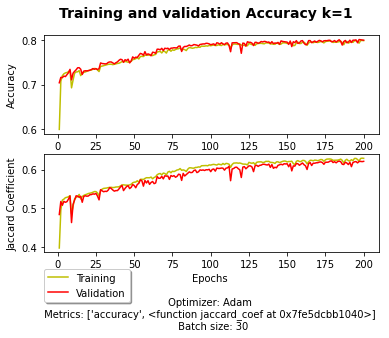

Epoch 1/200
70/70 [==============================] - 34s 393ms/step - loss: 0.6173 - accuracy: 0.6329 - jaccard_coef: 0.4310 - val_loss: 0.5561 - val_accuracy: 0.7036 - val_jaccard_coef: 0.4899
Epoch 2/200
70/70 [==============================] - 25s 362ms/step - loss: 0.5799 - accuracy: 0.6997 - jaccard_coef: 0.4893 - val_loss: 0.5933 - val_accuracy: 0.6721 - val_jaccard_coef: 0.4534
Epoch 3/200
70/70 [==============================] - 25s 363ms/step - loss: 0.5605 - accuracy: 0.6954 - jaccard_coef: 0.4927 - val_loss: 0.5467 - val_accuracy: 0.7051 - val_jaccard_coef: 0.4977
Epoch 4/200
70/70 [==============================] - 25s 362ms/step - loss: 0.5333 - accuracy: 0.7172 - jaccard_coef: 0.5185 - val_loss: 0.5316 - val_accuracy: 0.7141 - val_jaccard_coef: 0.5108
Epoch 5/200
70/70 [==============================] - 25s 362ms/step - loss: 0.5280 - accuracy: 0.7244 - jaccard_coef: 0.5239 - val_loss: 0.5338 - val_accuracy: 0.7094 - val_jaccard_coef: 0.5054
Epoch 6/200
70/70 [===========

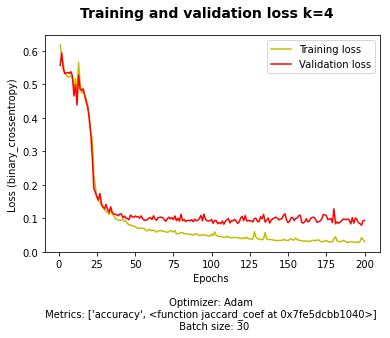

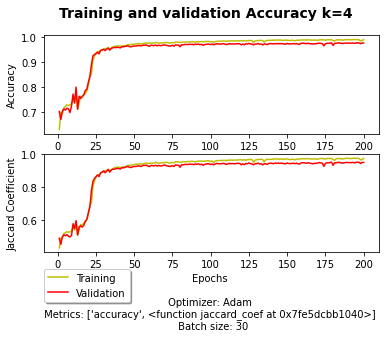

AVG Acc:  86.5138053894043 %
AVG Loss:  28.28875295817852 %
AVG IoU:  74.26710724830627 %


In [ ]:
# import time

# tic = time.clock() 

accuracy_list = []
loss_list = []
jaccard_coef_list =[]

k_fold = 5 #Number of folds

for n_routine in [1,4]:
  X_train, X_test, y_train, y_test = k_fold_method(images, masks, k_fold, n_routine)

  # cuda.close()
  # device = cuda.get_current_device() 
  # device.reset()
  history = None
  model = None

  model = get_model()
  model.compile(optimizer=optimizer, loss=loss_, metrics=metrics)
  history = model.fit(X_train, y_train, 
                      batch_size = batch_size, 
                      verbose = 1, 
                      epochs = n_epochs, 
                      validation_data=(X_test, y_test),
                      shuffle=False)

  model.save('/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/GO characterization/Results/Weights/5x5/Weights_CV_{}.hdf5'.format(n_routine))

  #Evaluatting the model
  #plotting the training and validation accuracy at each epoch
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.suptitle('Training and validation loss k={}'.format(n_routine), fontsize=14, fontweight='bold')
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.xlabel('Epochs \n \n Optimizer: {}  \n Metrics: {}  \n Batch size: {}'.format(optimizer, metrics, batch_size))
  plt.ylabel('Loss ({})'.format(loss_))
  plt.legend()
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/GO characterization/Results/Performance/5x5/Loss k={}'.format(n_routine))
  plt.show()

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  jac_coef = history.history['jaccard_coef']
  val_jac_coef = history.history['val_jaccard_coef']

  fig, (ax1, ax2) = plt.subplots(2, 1)
  fig.suptitle('Training and validation Accuracy k={}'.format(n_routine), fontsize=14, fontweight='bold')
  ax1.plot(epochs, acc, 'y', label='Training')
  ax1.plot(epochs, val_acc, 'r', label='Validation')
  ax1.set_ylabel('Accuracy')
  ax2.plot(epochs, jac_coef, 'y', label='Training')
  ax2.plot(epochs, val_jac_coef, 'r', label='Validation')
  ax2.set_ylabel('Jaccard Coefficient')
  ax2.set_xlabel('Epochs \n \n Optimizer: {}  \n Metrics: {}  \n Batch size: {}'.format(optimizer, metrics, batch_size))
  ax2.legend(loc=(0,-0.5), shadow=True, fontsize=10)
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/GO characterization/Results/Performance/5x5/Accuracy k={}'.format(n_routine))
  plt.show()

  ###################################################################################3
  accuracy_list.append(history.history['val_accuracy'][59])
  loss_list.append(history.history['val_loss'][59])
  jaccard_coef_list.append(history.history['val_jaccard_coef'][59])

# toc = time.clock()
# print('Time Training: ', (toc - tic) / (60 * 60))
print('AVG Acc: ',np.average(accuracy_list)*100, '%')
print('AVG Loss: ', np.average(loss_list)*100, '%')
print('AVG IoU: ', np.average(jaccard_coef_list)*100, '%')

Epoch 1/200
70/70 [==============================] - 34s 386ms/step - loss: 0.6528 - accuracy: 0.5823 - jaccard_coef: 0.3866 - val_loss: 0.6571 - val_accuracy: 0.6179 - val_jaccard_coef: 0.4502
Epoch 2/200
70/70 [==============================] - 25s 362ms/step - loss: 0.6072 - accuracy: 0.6918 - jaccard_coef: 0.4495 - val_loss: 0.5753 - val_accuracy: 0.7257 - val_jaccard_coef: 0.4587
Epoch 3/200
70/70 [==============================] - 25s 363ms/step - loss: 0.5437 - accuracy: 0.7243 - jaccard_coef: 0.5149 - val_loss: 0.5451 - val_accuracy: 0.7147 - val_jaccard_coef: 0.4867
Epoch 4/200
70/70 [==============================] - 25s 361ms/step - loss: 0.5278 - accuracy: 0.7269 - jaccard_coef: 0.5258 - val_loss: 0.4978 - val_accuracy: 0.7391 - val_jaccard_coef: 0.5396
Epoch 5/200
70/70 [==============================] - 25s 362ms/step - loss: 0.4887 - accuracy: 0.7546 - jaccard_coef: 0.5657 - val_loss: 0.4907 - val_accuracy: 0.7514 - val_jaccard_coef: 0.5406
Epoch 6/200
70/70 [===========

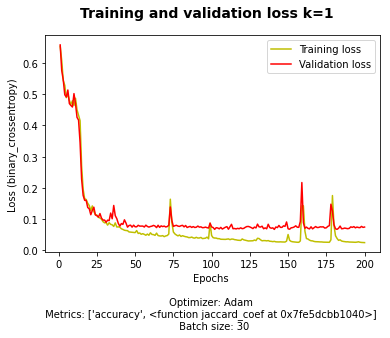

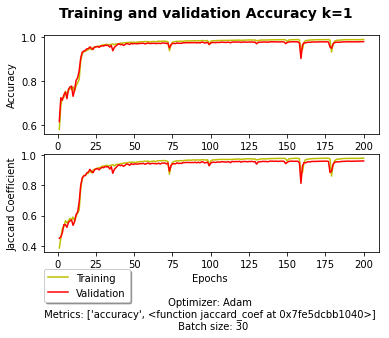

AVG Acc:  97.14568853378296 %
AVG Loss:  7.672169059514999 %
AVG IoU:  93.89345645904541 %


In [ ]:
# import time

# tic = time.clock() 

accuracy_list = []
loss_list = []
jaccard_coef_list =[]

k_fold = 5 #Number of folds

for n_routine in [1]:
  X_train, X_test, y_train, y_test = k_fold_method(images, masks, k_fold, n_routine)

  # cuda.close()
  # device = cuda.get_current_device() 
  # device.reset()
  history = None
  model = None

  model = get_model()
  model.compile(optimizer=optimizer, loss=loss_, metrics=metrics)
  history = model.fit(X_train, y_train, 
                      batch_size = batch_size, 
                      verbose = 1, 
                      epochs = n_epochs, 
                      validation_data=(X_test, y_test),
                      shuffle=False)

  model.save('/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/GO characterization/Results/Weights/5x5/Weights_CV_{}.hdf5'.format(n_routine))

  #Evaluatting the model
  #plotting the training and validation accuracy at each epoch
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.suptitle('Training and validation loss k={}'.format(n_routine), fontsize=14, fontweight='bold')
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.xlabel('Epochs \n \n Optimizer: {}  \n Metrics: {}  \n Batch size: {}'.format(optimizer, metrics, batch_size))
  plt.ylabel('Loss ({})'.format(loss_))
  plt.legend()
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/GO characterization/Results/Performance/5x5/Loss k={}'.format(n_routine))
  plt.show()

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  jac_coef = history.history['jaccard_coef']
  val_jac_coef = history.history['val_jaccard_coef']

  fig, (ax1, ax2) = plt.subplots(2, 1)
  fig.suptitle('Training and validation Accuracy k={}'.format(n_routine), fontsize=14, fontweight='bold')
  ax1.plot(epochs, acc, 'y', label='Training')
  ax1.plot(epochs, val_acc, 'r', label='Validation')
  ax1.set_ylabel('Accuracy')
  ax2.plot(epochs, jac_coef, 'y', label='Training')
  ax2.plot(epochs, val_jac_coef, 'r', label='Validation')
  ax2.set_ylabel('Jaccard Coefficient')
  ax2.set_xlabel('Epochs \n \n Optimizer: {}  \n Metrics: {}  \n Batch size: {}'.format(optimizer, metrics, batch_size))
  ax2.legend(loc=(0,-0.5), shadow=True, fontsize=10)
  plt.savefig('/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/GO characterization/Results/Performance/5x5/Accuracy k={}'.format(n_routine))
  plt.show()

  ###################################################################################3
  accuracy_list.append(history.history['val_accuracy'][59])
  loss_list.append(history.history['val_loss'][59])
  jaccard_coef_list.append(history.history['val_jaccard_coef'][59])

# toc = time.clock()
# print('Time Training: ', (toc - tic) / (60 * 60))
print('AVG Acc: ',np.average(accuracy_list)*100, '%')
print('AVG Loss: ', np.average(loss_list)*100, '%')
print('AVG IoU: ', np.average(jaccard_coef_list)*100, '%')

## Training with greater epoch and learning rate

In [ ]:
model = get_model()

metrics = ['accuracy', jaccard_coef]
loss_ = 'binary_crossentropy'
optimizer2 = tensorflow.optimizers.Adam(learning_rate=0.0005)
n_epochs2 = 50

model.compile(optimizer=optimizer2, loss=loss_, metrics=metrics)
# model.summary()

##Performance Tests

In [ ]:
acc = []
IoU =[]
fscore = []
confusion_matrix = []
# confusion_matrix_final = np.array([[0, 0], [0, 0]])

k_fold = 5

for n_routine in range(1,k_fold+1):
  model.load_weights('/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/GO characterization/Results/Weights/5x5/Weights_CV_{}.hdf5'.format(n_routine))

  X_train, X_test, y_train, y_test = k_fold_method(images, masks, k_fold, n_routine)

  tp, tn, fp, fn = 0, 0, 0, 0

  for i in range(0,256):
    
    #U-net input
    img = X_test[i]
    img = img[:,:,0][:,:,None]
    img = np.expand_dims(img, 0)

    #U-net output
    prediction = model.predict(img)
    predicted_img = np.argmax(prediction, axis=3)[0,:,:]

    #Output desired
    mask = y_test[i]
    mask = np.argmax(mask, axis=2)

    for i in range(0,len(mask)):
      for j in range(0, len(mask)):
        if (predicted_img[i,j]==0) and (mask[i,j]==0):
          tp += 1
        elif (predicted_img[i,j]==1) and (mask[i,j]==1):
          tn += 1
        elif (predicted_img[i,j]==0) and (mask[i,j]==1):
          fp += 1
        else:
          fn += 1

    acc_vol = (tp + tn)/(tp + fp + tn + fn)
    IoU_vol = tp/(tp+fp+fn)
    recal = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore_vol = 2 * ((recal * precision) / (recal + precision))

  acc.append(acc_vol)
  IoU.append(IoU_vol)
  fscore.append(fscore_vol)


  confusion_matrix.append(np.array([[tp, fp], [fn, tn]]))
  print('\n PASTA {} --------------------------------------------------------'.format(n_routine))
  print('Acc: ', acc[n_routine-1] * 100, '%')
  print('IoU: ', IoU[n_routine-1] * 100, '%')
  print('F-score: ', fscore[n_routine-1] * 100, '%')
  print('Confusion Matrix:')
  for x in confusion_matrix[n_routine-1]:
    print(x)
  
  #confusion_matrix_final = confusion_matrix_final + confusion_matrix

def std_calc(metric):
  avg_metric = sum(metric) / len(metric)
  sigma = 0
  for val in metric:
    sigma = sigma + (val - avg_metric)**2
  return np.sqrt(sigma/len(metric))


print('\n Final results:')
print('Acc: ', sum(acc) / len(acc) * 100, '%', '      std: ', std_calc(acc))
print('IoU: ', sum(IoU) / len(IoU) * 100, '%', '      std: ', std_calc(IoU))
print('F-score: ', sum(fscore) / len(fscore) * 100, '%', '      std: ', std_calc(fscore))
print('Confusion Matrix:')

confusion_matrix_final = sum(confusion_matrix)/sum(sum(confusion_matrix))*100
for x in confusion_matrix_final:
  print(x)

1/1 [==============================] - 0s 26ms/step

 PASTA 1 --------------------------------------------------------
Acc:  97.91875779628754 %
IoU:  95.90854232962783 %
F-score:  97.91154708124567 %
Confusion Matrix:
[32740231   536021]
[  860677 32971935]
1/1 [==============================] - 0s 32ms/step

 PASTA 2 --------------------------------------------------------
Acc:  96.75951153039932 %
IoU:  93.39133732172925 %
F-score:  96.58275144595724 %
Confusion Matrix:
[30731473  1173978]
[ 1000677 34202736]
1/1 [==============================] - 0s 26ms/step

 PASTA 3 --------------------------------------------------------
Acc:  94.03819590806961 %
IoU:  87.9774071718064 %
F-score:  93.6042352061994 %
Confusion Matrix:
[29277272  1500971]
[ 2499928 33830693]
1/1 [==============================] - 0s 27ms/step

 PASTA 4 --------------------------------------------------------
Acc:  97.73844331502914 %
IoU:  95.40369615263955 %
F-score:  97.64779073382009 %
Confusion Matrix:
[31502